In [2]:
using LinearAlgebra
using DSP: dpss

# Slepian/DPSS basis
function slepian_dpss_basis(N, NW, K)
    return dpss(N, NW, Int(K))
end

# Standard (regularized LS) reconstruction
function mse_slepian_reconstruction(y, N_basis, NW, λ)
    M = length(y)
    K = min(Int(N_basis), M)
    D = slepian_dpss_basis(M, NW, K)       # (M,K)
    lhs = D' * D + λ * I(K)                # (K,K)
    rhs = D' * y                           # (K,)
    c = lhs \ rhs
    return D * c, c, D                     # (M,), (K,), (M,K)
end

function reconstruct_signal(c, D)
    return D * c
end


reconstruct_signal (generic function with 1 method)

In [3]:
using LinearAlgebra

# Numerically stable Sinc dictionary (Eq. (3.4))
function sinc_dictionary(t_samples, σ)
    M = length(t_samples)
    D = zeros(M, M)
    for i in 1:M, j in 1:M
        x = σ * (t_samples[i] - t_samples[j])
        D[i, j] = abs(x) < 1e-10 ? 1.0 : sin(x) / (x) # Sinc(0) = 1
    end
    return D
end

# Standard least-squares Sinc signal reconstruction (Eq. (3.12))
function mse_sinc_reconstruction(y, t_samples, σ, λ)
    D = sinc_dictionary(t_samples, σ)
    c = (D' * D + λ * I) \ (D' * y)
    return c, D
end

# Reconstructed signal from coefficients and dictionary
function reconstruct_signal(c, D)
    return D * c
end


reconstruct_signal (generic function with 1 method)

In [4]:
using LinearAlgebra, Random
using DSP: dpss

# DPSS basis generator using DSP.jl
function slepian_dpss_basis(N, NW, K)
    # Returns a matrix (N × K) with K DPSS basis vectors of length N and time-bandwidth NW
    return dpss(N, NW, K)
end

# Gaussian kernel for correntropy
gaussian_kernel(x, sigma) = (1/sqrt(2π*sigma)) * exp(-(x^2)/(2*sigma^2))

# Entropy-based iterative robust solver (maximum correntropy)
function entropy_dpss_reconstruction(y, N_basis, NW, λ; maxiter=40, tol=1e-6)
    M = length(y)
    φ = slepian_dpss_basis(M, NW, N_basis)    # DPSS basis
    D = φ
    c = zeros(N_basis)
    w = ones(M)
    for it = 1:maxiter
        c_prev = copy(c)
        res = y - D * c
        sigma = sqrt(sum(res.^2) / (2*M))
        sigma = max(sigma, 1e-5)
        for i=1:M
            κ = gaussian_kernel(res[i], sigma)
            w[i] = ifelse(κ > 1e-12, 1 / (sigma^2 * κ), 1e6)
        end
        W = Diagonal(w)
        c = (D' * W * D + λ * I) \ (D' * W * y)
        if norm(c - c_prev) < tol
            @info "Converged at $it iterations"
            break
        end
    end
    return c, D
end

# Reconstruct signal at provided sample points
function reconstruct_signal(c, D)
    return D * c
end

reconstruct_signal (generic function with 1 method)

In [5]:
using LinearAlgebra, Random
using DSP: dpss
# --- Signal Setup and Noise ---
t = collect(0:0.001:1)
x_true = sin.(50 .* t .+ 0.1) .+ sin.(30 .* t .+ 0.8) .+ sin.(40 .* t .+ 0.5)


1001-element Vector{Float64}:
  1.296615046150554
  1.4015054952366752
  1.5045358304822118
  1.6055108673186518
  1.7042386786711394
  1.800530999482516
  1.894203624428766
  1.9850767979296555
  2.0729755955744373
  2.1577302961006177
  ⋮
 -0.6773285872275293
 -0.6465224541824304
 -0.6147530316076983
 -0.5820963590520298
 -0.5486304548258152
 -0.5144351029132237
 -0.4795916351838802
 -0.4441827094997275
 -0.4082920843244434

In [6]:
Random.seed!(42)
noise = 0.01 .* randn(length(t))
# High noise just in first region
noise_region = (t .>= 0.0) .& (t .<= 0.2)
noise[noise_region] .= 0.5 .* randn(sum(noise_region))
y_noisy = x_true + noise


1001-element Vector{Float64}:
  2.060895369307912
  1.019347552139364
  1.4071794700227587
  2.1205054568525346
  2.194942885210968
  1.5439354053684164
  2.0664841826996643
  1.0781783684587398
  1.055850239920167
  2.3050180932491844
  ⋮
 -0.6772549355274035
 -0.6512312152524204
 -0.617202152272386
 -0.5789265601212944
 -0.5403757031362335
 -0.5336950668904226
 -0.4698230633147203
 -0.4466461482490324
 -0.4103582154692553

In [7]:
# --- Sparse Sampling ---
sample_idx = vcat(1:5:20, 21:10:length(t))
y_samples = y_noisy[sample_idx]

103-element Vector{Float64}:
  2.060895369307912
  1.5439354053684164
  2.6415511745262066
  2.418422339752635
  3.167254037288533
  3.057292962886075
  2.261656483838229
  1.5397973085446466
 -0.37769274908461736
 -0.36102095550013913
  ⋮
  0.3364535567192202
  0.0906007501992119
 -0.254277289913802
 -0.5840660336334864
 -0.863996270015552
 -0.9851233857018604
 -0.947336336687005
 -0.732957962789363
 -0.4103582154692553

In [8]:
t_samples = t[sample_idx]
M = length(y_samples)
println("Number of samples: $M")
W = 0.4
NW = M * W
λ = 0.01
N_basis = min(Int(floor(NW )), M)-1

Number of samples: 103


40

In [9]:
# ===========Sinc reconstruction=====================
σ_sinc = 100
c_sinc, D_sinc = mse_sinc_reconstruction(y_samples, t_samples, σ_sinc, λ)
x_recon_sinc = D_sinc * c_sinc

103-element Vector{Float64}:
  1.7122220058099884
  2.0905484653037254
  2.430239512698926
  2.7038556869390575
  2.8859222280963133
  2.8975198879005033
  2.386532200105284
  1.42440272155696
  0.22471742914045517
 -0.9272380599173865
  ⋮
  0.3471440023488163
  0.10308093733313649
 -0.240787627620136
 -0.6008699889448793
 -0.877213198307228
 -0.9919696718713706
 -0.9227067611070856
 -0.7111426306645164
 -0.4412750846598285

In [10]:
# ========== Standard (MSE-based) Slepian/DPSS ==========
x_recon, c, D = mse_slepian_reconstruction(y_samples, N_basis, NW, λ)
x_recon_slep = reconstruct_signal(c, D)


103-element Vector{Float64}:
 -2.639115624010042e-8
 -8.708650134260503e-7
 -1.3823941380103012e-5
 -0.00014031050166646343
 -0.0010207096113874752
 -0.0056523889045379215
 -0.024692642044017825
 -0.08697612823986353
 -0.25017925810983793
 -0.5909444055665076
  ⋮
  0.07621097757839096
  0.028984254148368978
  0.008844997629005822
  0.0021499474791704387
  0.00040859872495115275
  5.8716033375146415e-5
  6.015703661783404e-6
  3.924347030898411e-7
  1.227288901661725e-8

In [11]:
# ========== Entropy-Based Robust Slepian/DPSS ==========
c_entropy, D_entropy = entropy_dpss_reconstruction(y_samples, N_basis, NW, λ)
x_recon_entropy = D_entropy * c_entropy

103-element Vector{Float64}:
 -1.1639470958256533e-8
 -3.888785849886117e-7
 -6.259170979155542e-6
 -6.452787367064694e-5
 -0.0004777828934922427
 -0.002699739361118594
 -0.012071457092781127
 -0.043688875488238126
 -0.1297585718984583
 -0.31851120370644753
  ⋮
  0.042937873726968855
  0.015767873358874557
  0.004672292451285862
  0.0011073646135261134
  0.00020587113188351346
  2.901458622110113e-5
  2.921661205935405e-6
  1.8765674778447634e-7
  5.786928994633573e-9

In [12]:
println("Reconstruction complete.")
# ==============Reconstruction Error================
# # MSE:
# mse = sum((x_true .- x_recon).^2) / M
# # RMSE:
# rmse = sqrt(mse)
# # Absolute error:
# abs_err = sum(abs.(x_true .- x_recon))
# FOR SINC RECONSTRUCTION
mse_sinc = sum((x_true[sample_idx] .- x_recon_sinc).^2) / M
rmse_sinc = sqrt(mse_sinc)
abs_err_sinc = sum(abs.(x_true[sample_idx] .- x_recon_sinc))
println("Sinc Reconstruction - MSE: $mse_sinc, RMSE: $rmse_sinc, Abs Error: $abs_err_sinc")
# FOR MSE-BASED DPSS RECONSTRUCTION
mse_slep = sum((x_true[sample_idx] .- x_recon_slep).^2) / M
rmse_slep = sqrt(mse_slep)
abs_err_slep = sum(abs.(x_true[sample_idx] .- x_recon_slep))
println("MSE-based DPSS Reconstruction - MSE: $mse_slep, RMSE: $rmse_slep, Abs Error: $abs_err_slep")
# FOR ENTROPY-BASED DPSS RECONSTRUCTION
mse_entropy = sum((x_true[sample_idx] .- x_recon_entropy).^2) / M
rmse_entropy = sqrt(mse_entropy)
abs_err_entropy = sum(abs.(x_true[sample_idx] .- x_recon_entropy))
println("Entropy-based DPSS Reconstruction - MSE: $mse_entropy, RMSE: $rmse_entropy, Abs Error: $abs_err_entropy")


Reconstruction complete.
Sinc Reconstruction - MSE: 0.02423281957256235, RMSE: 0.15566894222214767, Abs Error: 7.5494397687051915
MSE-based DPSS Reconstruction - MSE: 0.5046931935836093, RMSE: 0.7104176191393407, Abs Error: 35.042344016640115
Entropy-based DPSS Reconstruction - MSE: 0.5277984335247409, RMSE: 0.72649737337773, Abs Error: 33.526193057714615


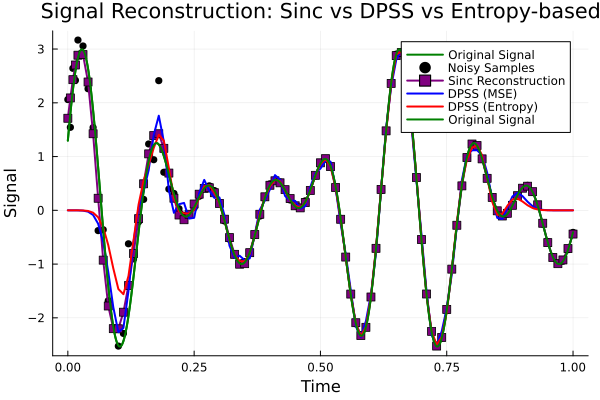

In [13]:
using Plots
plot(t, x_true, color=:green, label="Original Signal", linewidth=2)
scatter!(t_samples, y_samples, color=:black, label="Noisy Samples", markerstrokewidth=0)
plot!(t_samples, x_recon_sinc, color=:purple, label="Sinc Reconstruction", linewidth=2, marker=:square)
plot!(t_samples, x_recon_slep, color=:blue, label="DPSS (MSE)", linewidth=2, marker=:none)
plot!(t_samples, x_recon_entropy, color=:red, label="DPSS (Entropy)", linewidth=2, marker=:none)
plot!(t, x_true, color=:green, label="Original Signal", linewidth=2)
xlabel!("Time")
ylabel!("Signal")
title!("Signal Reconstruction: Sinc vs DPSS vs Entropy-based")

Using 799 Slepian basis functions with time-bandwidth product NW=400.40000000000003
Eigenvalues: [1.0, 1.0000000000000002, 1.0000000000000002, 0.9999999999999996, 1.000000000000001, 0.9999999999999993, 1.0000000000000018, 1.0000000000000016, 0.9999999999999991, 0.9999999999999997, 1.000000000000001, 0.9999999999999987, 0.999999999999999, 0.9999999999999993, 1.0000000000000007, 0.9999999999999996, 0.9999999999999991, 0.9999999999999987, 1.0000000000000004, 0.9999999999999991, 0.9999999999999996, 0.9999999999999997, 0.9999999999999987, 1.000000000000001, 0.9999999999999984, 1.0000000000000009, 0.999999999999999, 0.9999999999999999, 0.9999999999999982, 0.9999999999999997, 1.0000000000000009, 1.0000000000000016, 0.9999999999999996, 0.9999999999999999, 0.9999999999999993, 1.0000000000000013, 1.0, 0.9999999999999991, 0.9999999999999996, 1.0000000000000009, 1.0000000000000007, 1.000000000000001, 1.0000000000000018, 0.9999999999999991, 1.0000000000000009, 0.9999999999999997, 0.9999999999999997

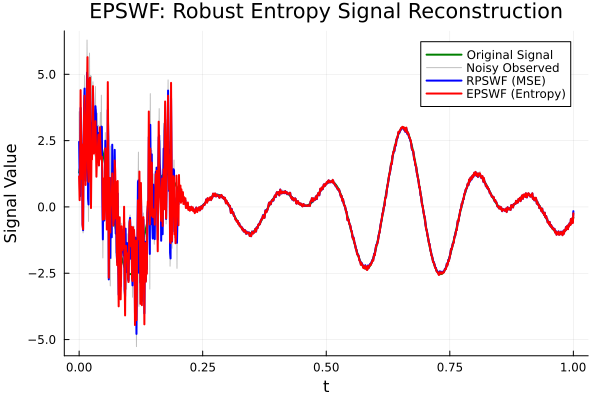

In [14]:
using LinearAlgebra, Random
using DSP
using Plots

# 1. Dense sampling
t = collect(0:0.001:1)            
x_true = sin.(50 .* t .+ 0.1) .+ sin.(30 .* t .+ 0.8) .+ sin.(40 .* t .+ 0.5)

Random.seed!(42)
noise = 0.05 .* randn(length(t))  # base noise
noise_region = findall(t .<= 0.2)
noise[noise_region] .= 1.5 .* randn(length(noise_region))  # impulsive region
y_noisy = x_true + noise

# 2. Use only key Slepian basis functions
W = 0.4
NW = length(t) * W
N_basis = Int(floor(2*NW)) - 1
D = dpss(length(t), NW, N_basis)
# print the eigenvalues
M, N = size(D)
println("Using $N Slepian basis functions with time-bandwidth product NW=$NW")
eigvalues=dpsseig(D, NW)
println("Eigenvalues: ", eigvalues)
λ = 0.01

function gaussian_kernel(x, sigma)
    1 / sqrt(2 * pi * sigma) * exp(-x^2/(2*sigma^2))
end

function entropy_dpss_reconstruction(y, D, λ; maxiter=40, tol=1e-6)
    M, N = size(D)
    c = zeros(N)
    w = ones(M)
    for it = 1:maxiter
        c_prev = copy(c)
        res = y - D * c
        sigma = sqrt(sum(res.^2) / (2*M))
        sigma = max(sigma, 1e-2)
        for i = 1:M
            κ = gaussian_kernel(res[i], sigma)
            w[i] = min(max(1 / (sigma^2 * max(κ,1e-12)), 1e-6), 1e6)
        end
        W = Diagonal(w)
        c = (D' * W * D + λ * I(N)) \ (D' * W * y)
        if norm(c - c_prev) < tol
            break
        end
    end
    return D * c
end

x_recon_entropy = entropy_dpss_reconstruction(y_noisy, D, λ)
x_recon_rpswf = (D' * D + λ * I(N_basis)) \ (D' * y_noisy)
x_recon_rpswf = D * x_recon_rpswf

plot(t, x_true, color=:green, label="Original Signal", linewidth=2)
plot!(t, y_noisy, color=:gray, alpha=0.5, label="Noisy Observed", linewidth=1)
plot!(t, x_recon_rpswf, color=:blue, label="RPSWF (MSE)", linewidth=2)
plot!(t, x_recon_entropy, color=:red, label="EPSWF (Entropy)", linewidth=2)
xlabel!("t")
ylabel!("Signal Value")
title!("EPSWF: Robust Entropy Signal Reconstruction")



In [15]:
using Statistics
# For error metrics
mse_rpswf = mean((x_true - x_recon_rpswf).^2)
mse_entropy = mean((x_true - x_recon_entropy).^2)
println("MSE RPSWF: ", mse_rpswf)
println("MSE EPSWF: ", mse_entropy)

MSE RPSWF: 0.3964897542999158
MSE EPSWF: 0.40846828313122374


Number of samples: 100
Sample locations in [0,1]: [0.0, 0.011, 0.021, 0.032, 0.042, 0.053, 0.063, 0.074, 0.084, 0.095, 0.105, 0.116, 0.126, 0.137, 0.147, 0.158, 0.168, 0.179, 0.189, 0.2, 0.001, 0.014, 0.026, 0.039, 0.052, 0.064, 0.077, 0.09, 0.102, 0.115, 0.127, 0.14, 0.153, 0.165, 0.178, 0.191, 0.203, 0.216, 0.229, 0.241, 0.254, 0.267, 0.279, 0.292, 0.304, 0.317, 0.33, 0.342, 0.355, 0.368, 0.38, 0.393, 0.406, 0.418, 0.431, 0.444, 0.456, 0.469, 0.482, 0.494, 0.507, 0.519, 0.532, 0.545, 0.557, 0.57, 0.583, 0.595, 0.608, 0.621, 0.633, 0.646, 0.659, 0.671, 0.684, 0.697, 0.709, 0.722, 0.734, 0.747, 0.76, 0.772, 0.785, 0.798, 0.81, 0.823, 0.836, 0.848, 0.861, 0.874, 0.886, 0.899, 0.911, 0.924, 0.937, 0.949, 0.962, 0.975, 0.987, 1.0]
Using N_basis = 39 with NW = 20.0


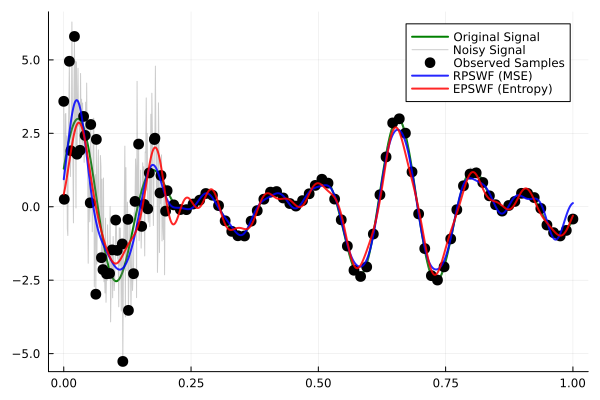

In [16]:
using LinearAlgebra, Random, DSP, Plots

# --- Signal setup (PSWF/Slepian experiment) ---
t_full = collect(0:0.001:1)                    
x_true = sin.(50 .* t_full .+ 0.1) .+ sin.(30 .* t_full .+ 0.8) .+ sin.(40 .* t_full .+ 0.5)

Random.seed!(42)
noise = 0.05 .* randn(length(t_full))           # baseline Gaussian noise everywhere
impulse_region = findall(t_full .<= 0.2)
noise[impulse_region] .= 1.5 .* randn(length(impulse_region)) # strong impulsive outliers for t <= 0.2
y_noisy = x_true + noise

# --- Sparse sample design: 16 samples in noisy region, 10 samples elsewhere ---
idx_noisy = round.(Int, range(1, length(impulse_region), length=20))   # ~16 in [0,0.2]
idx_rest  = round.(Int, range(minimum(impulse_region)+1, length(t_full), length=80)) # ~10 in [0.2,1]
sample_idx = vcat(idx_noisy, idx_rest)
sample_time = t_full[sample_idx]
y_samples = y_noisy[sample_idx]

println("Number of samples: ", length(y_samples))
println("Sample locations in [0,1]: ", sample_time)

# --- DPSS/PSWF basis construction (match time-bandwidth) ---      
NW = 20.0
N_basis = Int(floor(2 * NW)) - 1
println("Using N_basis = $N_basis with NW = $NW")
D_full = dpss(length(t_full), NW, N_basis)

# --- Build dictionary at sample points (rows corresponding to sample locations) ---
D_sparse = D_full[sample_idx, :]

# --- Correntropy kernel ---
function gaussian_kernel(x, sigma)
    1 / sqrt(2 * pi * sigma) * exp(-(x^2)/(2*sigma^2))
end

# --- Entropy-based robust solver (EPSWF) ---
function entropy_dpss_reconstruct(y, D, λ; maxiter=60, tol=1e-6)
    M, N = size(D)
    c = zeros(N)
    w = ones(M)
    for it in 1:maxiter
        c_prev = copy(c)
        res = y - D * c
        sigma = sqrt(sum(res.^2)/(2*M))
        sigma = max(sigma, 1e-2)
        for i in 1:M
            κ = gaussian_kernel(res[i], sigma)
            w[i] = min(max(1 / (sigma^2 * max(κ,1e-12)), 1e-6), 1e6)
        end
        W = Diagonal(w)
        c = (D' * W * D + λ * I(N)) \ (D' * W * y)
        if norm(c - c_prev) < tol
            println("EPSWF converged in $it iterations (tol=$tol)")
            break
        end
    end
    return c
end

function mse_sinc_reconstruction(y_samples, t_samples, sigma_sinc, λ; t_grid=nothing)
    # t_samples: sample times, y_samples: observed sample values
    # sigma_sinc: bandwidth, λ: regularization
    # t_grid: reconstruction grid (default: t_samples)
    if t_grid === nothing
        t_grid = t_samples
    end
    M = length(t_samples)
    N = length(t_grid)
    D_sinc = zeros(M, N)
    for i in 1:M
        for j in 1:N
            x = sigma_sinc * (t_samples[i] - t_grid[j])
            D_sinc[i, j] = abs(x) < 1e-12 ? 1.0 : sin(x)/x
        end
    end
    # Regularized LSQ
    c_sinc = (D_sinc' * D_sinc + λ * I(N)) \ (D_sinc' * y_samples)
    return D_sinc, c_sinc
end

λ = 0.01          # regularization parameter

# --- EPSWF robust reconstruction (from sparse, noisy samples) ---
c_epswf = entropy_dpss_reconstruct(y_samples, D_sparse, λ)
x_recon_epswf = D_full * c_epswf         # reconstruct on full [0,1] grid

# --- RPSWF (MSE least squares) reconstruction ---
c_rpswf = (D_sparse' * D_sparse + λ * I(N_basis)) \ (D_sparse' * y_samples)
x_recon_rpswf = D_full * c_rpswf

# SINC RECONSTRUCTION
σ_sinc = 100
D_sinc, c_sinc = mse_sinc_reconstruction(y_samples, sample_time, σ_sinc, λ; t_grid=t_full) 
x_recon_sinc = D_sinc * c_sinc

# --- Plot results ---
plot(t_full, x_true, color=:green, label="Original Signal", linewidth=2)
plot!(t_full, y_noisy, color=:gray, alpha=0.4, label="Noisy Signal", linewidth=1)
scatter!(sample_time, y_samples, color=:black, markersize=6, label="Observed Samples")
# plot!(t_full, x_recon_sinc, color=:purple, linewidth=2, label="Sinc Reconstruction", alpha=0.85)
plot!(t_full, x_recon_rpswf, color=:blue, linewidth=2, label="RPSWF (MSE)", alpha=0.85)
plot!(t_full, x_recon_epswf, color=:red, linewidth=2, label="EPSWF (Entropy)", alpha=0.85)
# 
# # xlabel!("t")
# ylabel!("Signal Value")
# title!("EPSWF: Robust Reconstruction from Sparse Noisy Samples")


In [17]:
# --- Quantitative evaluation ---
mse_epswf = mean((x_true - x_recon_epswf).^2)
mse_rpswf = mean((x_true - x_recon_rpswf).^2)
println("MSE EPSWF: ", mse_epswf)
println("MSE RPSWF: ", mse_rpswf)

MSE EPSWF: 0.09448436194104788
MSE RPSWF: 0.0634317472789205


In [18]:
using LinearAlgebra
using DSP: dpss

# DPSS/PSWF dictionary construction (uniform grid)
function build_dpss_dictionary(num_samples::Int, NW::Float64, K::Int)
    # Returns (num_samples, K) matrix
    return dpss(num_samples, NW, K)
end

# Robust coefficient solver (maximum correntropy, Eq. (3.13)-(3.21))
function solve_epswf_coefficients(
    y::Vector{Float64},         # observed samples
    D::AbstractMatrix{Float64}, # dictionary matrix (basis evaluated at sample points)
    λ::Float64;                 # regularization parameter
    maxiter=40, tol=1e-6
)
    M, N = size(D)
    c = zeros(N)
    w = ones(M)
    for it=1:maxiter
        c_prev = copy(c)
        res = y - D*c
        sigma = sqrt(sum(res.^2)/(2*M))          # Eq. (3.22)
        sigma = max(sigma, 1e-5)
        for i=1:M
            kappa = (1/sqrt(2π*sigma)) * exp(-(res[i]^2)/(2*sigma^2))
            w[i] = kappa > 1e-12 ? 1/(sigma^2*kappa) : 1e8           # avoid divide-by-zero
        end
        W = Diagonal(w)
        c = (D' * W * D + λ * I) \ (D' * W * y)                      # Eq. (3.21)
        if norm(c - c_prev) < tol
            @info "EPSWF converged in $it iterations"
            break
        end
    end
    return c
end


solve_epswf_coefficients (generic function with 1 method)

In [19]:
# Signal reconstruction from coefficients and basis (Eq. (3.15))
function reconstruct_epswf_signal(c::Vector{Float64}, D::AbstractMatrix{Float64})
    # D: dictionary matrix, c: expansion coefficients
    return D * c
end


reconstruct_epswf_signal (generic function with 1 method)

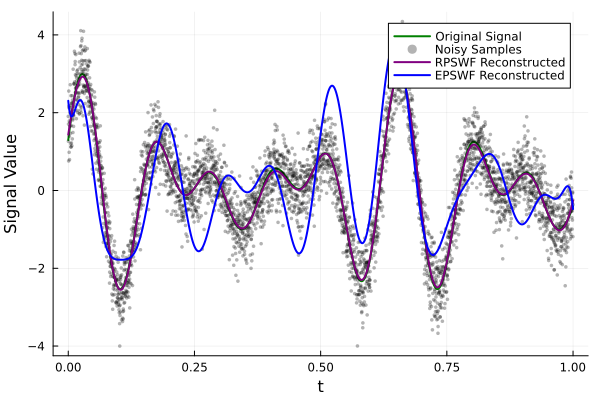

In [20]:
using Plots, Random, LinearAlgebra, DSP
# Synthetic test signal
M = 4000                     # number of samples
t = range(0, 1, length=M)   # time grid
x_true = sin.(50t .+ 0.1) .+ sin.(30t .+ 0.8) .+ sin.(40t .+ 0.5)
noisy = x_true .+ 0.5*randn(M)
y_samples = noisy
# Reconstruction parameters
NW = 8.0
K = 25
λ = 1e-2

D = build_dpss_dictionary(M, NW, K)
c = solve_epswf_coefficients(noisy, D, λ)
recon = reconstruct_epswf_signal(c, D)
x_recon, c, D = mse_slepian_reconstruction(y_samples,K, NW, λ)
x_recon_slep = reconstruct_signal(c, D)
# Plot ground truth vs noisy input vs reconstruction
plot(t, x_true, lw=2, label="Original Signal", color=:green)
plot!(t, noisy, seriestype=:scatter, alpha=0.3, markersize=2, label="Noisy Samples", color=:black)
plot!(t, x_recon_slep, lw=2, label="RPSWF Reconstructed", color=:purple)
plot!(t, recon, lw=2, label="EPSWF Reconstructed", color=:blue)
xlabel!("t")
ylabel!("Signal Value")

In [21]:
# Compute RMSE
using  Statistics
rmse_rpswf = sqrt(mean((x_true - x_recon_slep).^2))
rmse_epswf = sqrt(mean((x_true - recon).^2))
println("RMSE RPSWF: ", rmse_rpswf)
println("RMSE EPSWF: ", rmse_epswf)

RMSE RPSWF: 0.03365373901776241
RMSE EPSWF: 0.956092147721753


In [29]:
x_recon_slep

4000-element Vector{Float64}:
  1.4363727005406282
  1.4579088344069862
  1.4793881605291899
  1.5008081340565516
  1.5221661994320417
  1.5434597909776209
  1.5646863334797958
  1.5858432427754732
  1.6069279263379483
  1.6279377838627933
  ⋮
 -0.36828066205708637
 -0.35465687667262097
 -0.34089038847859415
 -0.3269812083442657
 -0.31292934937915684
 -0.298734826892331
 -0.2843976583530452
 -0.2699178633527949
 -0.2552954635687494

In [31]:

C = cov(x_recon_slep)
# C=cov(c)
vals, vecs = eigen(C)
println("Covariance eigenvalues (variance per mode): ", vals)
vecs

Covariance eigenvalues (variance per mode): [1.5998377025055313]


1×1 Matrix{Float64}:
 1.0

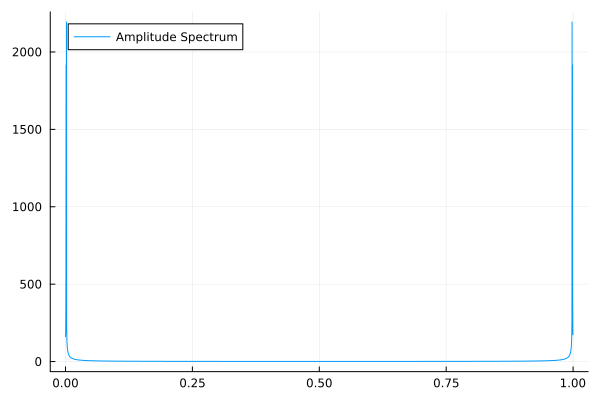

In [23]:
using FFTW
X = fft(x_recon_slep)
N = length(x_recon_slep)
freqs = collect(0:N-1) / N     
plot(freqs, abs.(X), label="Amplitude Spectrum")


In [27]:
using DSP
ar_model = arburg(x_recon_slep, 10)
println("AR model: ", ar_model)


AR model: ([1.0, -4.02219263758286, 6.066493116042921, -4.066414318343116, 1.0221136905073818, -7.390589613297782e-9, -7.958759906519766e-9, 0.007677557187096569, -0.02271485468725933, 0.022402190788517573, -0.007364719011346598], -8.438830660355427e-15, [-0.999951304240373, 0.9999916705933268, -0.9999492489674846, 1.0158826345703444, -0.006666432448793422, -0.006801795851575203, -0.006939186105496897, -0.0070787192940694205, -0.007220519431162463, -0.007364719011346598])
